# Домашнее задание 
# Математика — Домашнее задание 14

# А.&#8201;Д. Егоров

In [1]:
import numpy as np 
from scipy import optimize as opt 
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple

# Подгрузим полезные функции
from utils import *

# Сделаем автоподгрузку всех изменений при перепрогонке ячейки
%load_ext autoreload
%autoreload 2

# plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
%matplotlib inline
# sns.set_palette(palette="Reds")


## Задание $№\,1$

### Условие

> $r$ - restricted, $u$ - unrestricted 

Из формулы 
$$
F = \dfrac{(RSS_r - RSS_u) / q}{RSS_u / (n - k - 1)}
$$
получить формулу
$$
F = \dfrac{(R^2_u - R^2_r) / q}{(1 - R^2_u) / (n - k - 1)}
$$

### Решение

Запишем основные соотношения:
$$
    RSS_r = RSS / df_r, \quad RSS_u = RSS / df_u,
$$
$$
R^2_{r} = 1 - \dfrac{RSS / df_r}{TSS / df_t},
\quad
R^2_{u} = 1 - \dfrac{RSS / df_u}{TSS / df_t}.
$$

Подставим их в формулу для $F$-статистики и упростим
$$
F = \dfrac{(RSS_r - RSS_u) / q}{RSS_u / (n - k - 1)} = \dfrac{\left( (1 - R^2_r) TSS / df_t - (1 - R^2_u) TSS / df_t\right) / q}{\left( (1 - R^2_u) TSS / df_t \right) / (n - k - 1)} = \dfrac{(R^2_u - R^2_r) / q}{(1 - R^2_u) / (n - k - 1)}.
$$

Окончательно получим 
$$
F = \dfrac{(R^2_u - R^2_r) / q}{(1 - R^2_u) / (n - k - 1)}.
$$

## Задание $№\,2$

### Условие
Сгенерируйте датасет со случайными нормально распределенными величинами
$$
    x_1 \sim N\left( \mu_1, \sigma_1^2 \right), 
    \quad 
    x_2 \sim N\left( \mu_2, \sigma_2^2 \right),
    \quad
    x_3 \sim N\left( \mu_3, \sigma_3^2 \right),
$$
$$
    corr(x_1, x_2) = 0.0, 
    \quad
    corr(x_1, x_3) = 0.0, 
    \quad
    corr(x_2, x_3) = 0.8, 
$$
размер выборки $N = 1000$.

Сгенерируйте зависимую переменную $y$ по формуле
$$
    y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 + \varepsilon,
$$
где $\varepsilon \sim N\left(0, \sigma_\varepsilon^2\right), \ \beta_i \ne 0, \ i = \overline{0, 3}.$

Требуется: 

Оценить коэффициенты модели с помощью МНК, вывести репорт с результатами модели, дать трактовку полученным результатам:

1. Значения оценок $\widehat\beta_1, \widehat\beta_2, \widehat\beta_3$ в сравнении с реальными коэффициентами.
2. Значения стандартных ошибок коэффициентов, значения t-статистик, p-value, доверительных интервалов.
3. Значения $F$-статистики, критериев AIC и BIC

### Решение

### Пункт 1

In [2]:
# Определим параметры выборки для задачи пропущенной переменной
# Создадим удобный словарь, чтобы передавать его в функцию
dist_params = dict(

    # Зададим параметры распределения факторов
    x1_mean = 10.0,
    x1_std = 10.0,
    x2_mean = 20.0,
    x2_std = 12.0,
    x3_mean = 7.0,
    x3_std = 20.0,
    corr_12 = 0.0,
    corr_13 = 0.0,
    corr_23 = 0.8,
    
    # Зададим параметры распределения ошибки
    e_mean = 0.0,
    e_std = 8.0,

    # Укажем размер выборки
    N = 1000,

    # Зададим действительные параметры модели
    beta0 = 33.0,
    beta1 = 7.0,
    beta2 = -5.0,
    beta3 = 44.0,
)

# Установим стартовую точку для алгоритма генерации случайных чисел
RANDOM_SEED = 42

,x1,x2,x3,e,y
0,8.617357,11.077313,-0.856851,-15.262460,-15.028985
1,7.658466,5.211952,-23.818434,-6.883080,-994.344650
2,17.674347,5.950081,-25.642279,-3.308844,-1004.599072
3,5.365823,16.896762,-5.137250,15.101501,-224.860564
4,-9.132802,27.207010,-3.010510,4.452425,-294.974684
...,...,...,...,...,...
995,8.772911,29.628679,26.262193,0.227661,1102.031133
996,34.116767,23.371392,33.938330,-16.622495,1631.624442
997,10.720369,14.831121,-5.546402,-2.562382,-212.717086
998,10.774805,28.611917,26.599646,13.147025,1148.895483


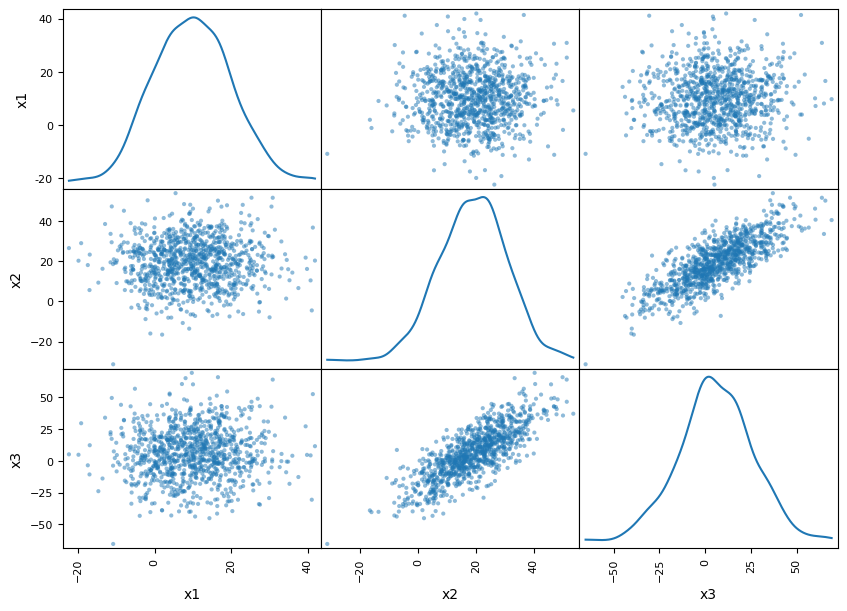

In [3]:
# Сгенерируем датасет

# DONE:
# Дописана новая функции на основе функции gen_data из utils
# для генерации данных с двумя переменными
dt_var = gen_data(y_type='multivariate', params=dist_params, seed=RANDOM_SEED)

display(dt_var)

# Посмотрим на корреляции глазами
pd.plotting.scatter_matrix(dt_var[["x1", "x2", "x3"]], figsize = (10,7), diagonal = 'kde');

#### Обучение модели
Строим линейную модель, чтобы найти взаимосвязь между нашими факторами x1, x2 и таргетом y:

In [4]:
# Обучим модель и выведем результаты
dt_var, model_vars = train_model(
    dt_var, 
    target='y', 
    feature_names=['x1', 'x2', 'x3',], 
    show_results=False, 
    return_norm_tests=False,
)

#### Репорт

In [5]:
print(model_vars.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.299e+06
Date:                Thu, 07 Mar 2024   Prob (F-statistic):               0.00
Time:                        17:12:59   Log-Likelihood:                -3523.5
No. Observations:                1000   AIC:                             7055.
Df Residuals:                     996   BIC:                             7075.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         32.4832      0.713     45.540      0.0

Выводы:
1. Значения оценок $\widehat\beta_1, \widehat\beta_2, \widehat\beta_3$ близки с реальными коэффициентами (абсолютная ошибка не больше, чем на 0.04).
2. Значения стандартных ошибок коэффициентов малы. 
Значения t-статистик и p-value показывают, что нулевая гипотеза ($x_i$ не влияет на значение $y$) отклоняется, т.е. все переменные значимы.
Доверительных интервалы достаточно узкие и реальные значения коэффициентов лежат в них.
3. Значения $F$-статистики показывают, что мы так же как и в $t$-тесте отклоняем нулевую гипотезу. Значения критериев AIC и BIC будут значимы, если мы будем сравнивать данную модель с какой-то другой (чем меньше значение критерия, тем лучше).
